In [1]:
import json
import pandas as pd
import numpy as np
import gc
import datetime
import re
import seaborn as sns
import matplotlib.pyplot as plt

#### functions for loading data

In [2]:
def get_business_data(file_name, state="AZ"):
    '''
    The function is designed to extract business data from the 
    given file name
    Inputs: 
        file_name: file name
        state: the specified state
    Return: dataframe for the business
    '''
    business = []

    with open(file_name, encoding="utf8") as fl:
        for i, line in enumerate(fl):
            business.append(json.loads(line))
            if i + 1 >= 100000:
                break

    df_business = pd.DataFrame(business)
    df_business = df_business[df_business["state"] == state]
    return df_business

In [3]:
def get_review_data(df_business, start_year, file_name, subset_n=5*(10**5)):
    '''
    The function is used to derive the reviews from the given file, using the
    businesses listed in the df_business. Start year and the total row size
    of review dataframe should also be specified.
    Inputs:
        df_business: dataframe for businesses
        start_year: starting year for rewiew data
        file_name: file name for review data
        subset_n: total row size searched in review dataframe
    '''
    reviews = []
    begin_date =  datetime.datetime(start_year, 1, 1, 0, 0)
    full_reviews = pd.DataFrame(columns=["business_id", "user_id", "stars", "date"])

    count = 0
    with open(file_name, encoding="utf8") as fl:
        for i, line in enumerate(fl):
            reviews.append(json.loads(line))
            count += 1
            if count + 1 >= 10000:
                df_reviews = pd.DataFrame(reviews)
                df_reviews['date'] = pd.to_datetime(df_reviews['date'])
                df_reviews = df_reviews[(df_reviews['date'] - begin_date) > datetime.timedelta(days = 0)]
                df_reviews = df_reviews[df_reviews["business_id"].isin(df_business["business_id"])]
                full_reviews = pd.concat([full_reviews, df_reviews[["business_id", "user_id", "stars", "date"]]], join="inner")
                df_reviews = ""
                count = 0
                gc.collect()
                print("currently, full_reviews contain: ", full_reviews.shape[0], " rows")
                if i + 1 > subset_n:
                    break
    
    return full_reviews

In [4]:
def get_final_matrix(full_reviews, review_threshold):
    '''
    The function is used to drop duplicated review and keep the latest one for a business-customer
    pair. A dataframe with customers and their corresponding rating (to all restaurant) will be returned.
    In order to control the sparsity of the matrix, only businesses who have review more than the review
    threshold will be included.
    Inputs: 
        full_review: review dataframe
        review_threshold: the minimum review for a customer
    Return: matrix for every business-customer pair
    '''
    final_matrix = full_reviews.sort_values(by="date", ascending=False).drop_duplicates(
                           subset=["business_id","user_id"], keep='first', inplace=False)
    final_matrix = final_matrix[["business_id","user_id", "stars"]].pivot(
                           index='business_id', columns='user_id', values='stars')
    return final_matrix[final_matrix.count(axis = 1) > review_threshold]

#### functions for imputation

In [5]:
def initial_imputer(df, indicator_matrix=True):
    '''
    The function is used to impute the missing value in the customer-business
    matrix and generate a complete dataframe. The missing value of each row will
    be replaced by the random draw from the normal distribution (which is assumed)
    of reviews for each business.
    Inputs:
        df: business-customer matrix
    Return: complete matrix, matrix of missing indicator
    '''
    for idx in np.arange(0, df.shape[0], 1):
        mu = df[idx, :][~np.isnan(df[idx, :])].mean()
        sigma = df[idx, :][~np.isnan(df[idx, :])].std()
        null_num = len(df[idx,:][np.isnan(df[idx, :])])
        imputed_vals = np.random.normal(mu, sigma, null_num)
        df[idx,:][np.isnan(df[idx, :])] = imputed_vals
    
    if indicator_matrix:
        ind_matrix = np.isnan(df)
        return df, ind_matrix
    
    return df

#### functions for NMF & SVD

In [6]:
def nmf(X, k, max_iter, epsilon, l_rate=1, use_l_rate=False):
    '''
    Non-negative matrix factorization with multiplicative updates
    Inputs:
        X: (numpy array)matrix
        k: (int)dimension to keep
        max_iter: (int) the maximum number of iteration
        epsilon: the threshold to stop iteration
        l_rate: learning rate specified
        use_l_rate: if True, use the arbitrary learning rate
    Outputs:
        two decomposition matrix: W & H
    '''
    U, sigma, Vt = np.linalg.svd(X, full_matrices=False)
    U[np.where(U <= 0)] = -U[np.where(U <= 0)]
    Vt[np.where(Vt <= 0)] = -Vt[np.where(Vt <= 0)]
        
    
    init_W = U[:, :k].dot(np.diag(sigma[:k]))
    init_W[init_W <= 0] = 0
    init_H = Vt[:k, :]
    init_H[init_H <= 0] = 0
    
    W = init_W
    H = init_H
    W_gradient = - X.dot(H.T) + W.dot(H).dot(H.T)
    H_gradient = - W.T.dot(X) + W.T.dot(W).dot(H)
    H_r = np.divide(H, (W.T.dot(W).dot(H)))
    W_r = np.divide(W, (W.dot((H.dot(H.T)))))

    for i in np.arange(0, max_iter, 1):
        
        if use_l_rate:
            W = W - l_rate * W_gradient
        else:
            W = W - np.multiply(W_r, W_gradient)
            W_r = np.divide(W, (W.dot(H).dot(H.T)))

        W_gradient = - X.dot(H.T) + W.dot(H).dot(H.T)
        W[np.where(W <= 0)] = init_W[np.where(W <= 0)]
        
        if use_l_rate:
            H = H - l_rate * H_gradient
        else:
            H = H - np.multiply(H_r, H_gradient)
            H_r = np.divide(H, (W.T.dot(W).dot(H)))

        H_gradient = - W.T.dot(X) + W.T.dot(W).dot(H)
        H[np.where(H <= 0)] = init_H[np.where(H <= 0)]

        if np.linalg.norm(X - W.dot(H)) < epsilon:
            print("the stopping condition is reached, the estimated matrix is similar enough to the origin")
            print("the number of iteration is {}".format(i))
            break
    
    print("the max iteration is reached")
    return W, H

In [7]:
def nmf_two_block(X, k, max_iter, epsilon, l_rate=1, use_l_rate=False):
    '''
    Non-negative matrix factorization with multiplicative updates
    using two block gradient descent algorithm
    Inputs:
        X: (numpy array)matrix
        k: (int)dimension to keep
        max_iter: (int) the maximum number of iteration
        epsilon: the threshold to stop iteration
        l_rate: learning rate specified
        use_l_rate: if True, use the arbitrary learning rate
    Outputs:
        two decomposition matrix: W & H
    '''
    U, sigma, Vt = np.linalg.svd(X, full_matrices=False)
    U[np.where(U <= 0)] = -U[np.where(U <= 0)]
    Vt[np.where(Vt <= 0)] = -Vt[np.where(Vt <= 0)]
        
    
    init_W = U[:, :k].dot(np.diag(sigma[:k]))
    init_W[init_W <= 0] = 0
    init_H = Vt[:k, :]
    init_H[init_H <= 0] = 0
    
    W = init_W
    H = init_H
    W_gradient = - X.dot(H.T) + W.dot(H).dot(H.T)
    H_gradient = - W.T.dot(X) + W.T.dot(W).dot(H)
    H_r = np.divide(H, (W.T.dot(W).dot(H)))
    W_r = np.divide(W, (W.dot((H.dot(H.T)))))
    
    for i in np.arange(0,max_iter,1):
        if i == 0:
            first_norm = np.linalg.norm(W - (W - np.multiply(W_r, W_gradient)))
            #print(first_norm)
        current_norm = np.linalg.norm(W - (W - np.multiply(W_r, W_gradient)))
        #print(current_norm)
        
        if use_l_rate:
            W = W - l_rate * W_gradient
        else:
            W = W - np.multiply(W_r, W_gradient)
            W_r = np.divide(W, (W.dot(H).dot(H.T)))

        W_gradient = - X.dot(H.T) + W.dot(H).dot(H.T)
        W[np.where(W <= 0)] = init_W[np.where(W <= 0)]
        
        if current_norm <= epsilon * first_norm:
            print("the stopping condition is reached, the estimated matrix is similar enough to the origin")
            print("the number of iteration is {}".format(i))
            break
                        
    for j in range(max_iter):
        if i == 0:
            first_norm = np.linalg.norm(H - (H - np.multiply(H_r, H_gradient)))
        current_norm = np.linalg.norm(H - (H - np.multiply(H_r, H_gradient)))
        
        if use_l_rate:
            H = H - l_rate * H_gradient
        else:
            H = H - np.multiply(H_r, H_gradient)
            H_r = np.divide(H, (W.T.dot(W).dot(H)))
            
        H_gradient = - W.T.dot(X) + W.T.dot(W).dot(H)
        H[np.where(H <= 0)] = init_H[np.where(H <= 0)]

        if current_norm <= epsilon * first_norm:
            print("the stopping condition is reached, the estimated matrix is similar enough to the origin")
            print("the number of iteration is {}".format(i))
            break
    
    print("the max iteration is reached")
    return W, H

In [8]:
def truncated_svd(X, k):
    '''
    Decompose matrix using truncated SVD
    Inputs:
        X: input matrix
        k: dimension to keep
    Outputs:
        new matrix constructed by truncated svd
    '''
    U, S, Vt = np.linalg.svd(X, full_matrices=False)
    U_k = U[:, :k]
    Vt_k = Vt[:k, :]
    S_k = S[:k]
    S_mat = np.diag(S_k)
    
    return U_k.dot(S_mat).dot(Vt_k)

### toy example

In [9]:
toy_matrix = np.array([[0, 1, 0, 1, 2, 2],
                      [2, 3, 1, 1, 2, 2],
                      [1, 1, 1, 0, 1, 1],
                      [0, 2, 3, 4, 1, 1],
                      [0, 0, 0, 0, 1, 0]])

In [10]:
W, H = nmf(toy_matrix, 4, 10000, 10**(-6), l_rate=0.01, use_l_rate=True)

the max iteration is reached


In [11]:
np.linalg.norm(toy_matrix - W.dot(H))

1.2232658184866345

In [12]:
W, H = nmf(toy_matrix, 4, 10000, 10**(-6))

the max iteration is reached


In [13]:
np.linalg.norm(toy_matrix - W.dot(H))

2.5104249369814102

In [14]:
W, H = nmf_two_block(toy_matrix, 4, 10000, 10**(-6), l_rate=1)

the stopping condition is reached, the estimated matrix is similar enough to the origin
the number of iteration is 677
the stopping condition is reached, the estimated matrix is similar enough to the origin
the number of iteration is 677
the max iteration is reached


In [15]:
np.linalg.norm(toy_matrix - W.dot(H))

1.762309427620005

In [16]:
W, H = nmf_two_block(toy_matrix, 4, 10000, 10**(-6), l_rate=0.05, use_l_rate=True)

the max iteration is reached


In [17]:
np.linalg.norm(toy_matrix - W.dot(H))

2.5445465497458035

In [18]:
svd_approx_toy = truncated_svd(toy_matrix, 4)

In [19]:
np.linalg.norm(toy_matrix - svd_approx_toy)

0.5915117127553415

### Yelp dataset

#### loading data

In [20]:
file_name = 'D:/Researching Data/yelp_academic_dataset_business.json'
df_business = get_business_data(file_name)

#### generating different dependent variable y

In [21]:
cat_null_idx = df_business["categories"].isnull()
df_business.loc[cat_null_idx, "categories"] = "no type"

def find_re(txt, pattern):
    if re.findall(pattern, txt) != []:
        return True
    return False

revec = np.vectorize(find_re, otypes=[bool])

In [22]:
file_name = 'D:/Researching Data/yelp_academic_dataset_review.json'
full_reviews = get_review_data(df_business, 2015, file_name)
final_matrix = get_final_matrix(full_reviews, 20)

currently, full_reviews contain:  2170  rows
currently, full_reviews contain:  6582  rows
currently, full_reviews contain:  13200  rows
currently, full_reviews contain:  22060  rows
currently, full_reviews contain:  33081  rows
currently, full_reviews contain:  46307  rows
currently, full_reviews contain:  61749  rows
currently, full_reviews contain:  79408  rows
currently, full_reviews contain:  99262  rows
currently, full_reviews contain:  121315  rows
currently, full_reviews contain:  145487  rows
currently, full_reviews contain:  171859  rows
currently, full_reviews contain:  200391  rows
currently, full_reviews contain:  231151  rows
currently, full_reviews contain:  264121  rows
currently, full_reviews contain:  299280  rows
currently, full_reviews contain:  336604  rows
currently, full_reviews contain:  376110  rows
currently, full_reviews contain:  417757  rows
currently, full_reviews contain:  461511  rows
currently, full_reviews contain:  507317  rows
currently, full_reviews 

In [23]:
italian_idx = df_business.loc[revec(np.array(df_business["categories"]), "Ital")]["business_id"]
mexican_idx = df_business.loc[revec(np.array(df_business["categories"]), "Mexi")]["business_id"]
chinese_idx = df_business.loc[revec(np.array(df_business["categories"]), "Chin")]["business_id"]

In [24]:
full_reviews["italian_ind"] = 0
full_reviews["mexican_ind"] = 0
full_reviews["chinese_ind"] = 0
full_reviews.loc[full_reviews["business_id"].isin(italian_idx), "italian_ind"] = 1
full_reviews.loc[full_reviews["business_id"].isin(mexican_idx), "mexican_ind"] = 1
full_reviews.loc[full_reviews["business_id"].isin(chinese_idx), "chinese_ind"] = 1

In [25]:
italian_y = full_reviews[full_reviews["italian_ind"] == 1].groupby("user_id").mean()["stars"].to_frame()
mexican_y = full_reviews[full_reviews["mexican_ind"] == 1].groupby("user_id").mean()["stars"].to_frame()
chinese_y = full_reviews[full_reviews["chinese_ind"] == 1].groupby("user_id").mean()["stars"].to_frame()

In [26]:
final_matrix = full_reviews.sort_values(by="date", ascending=False).drop_duplicates(
                           subset=["business_id","user_id"], keep='first', inplace=False)
final_matrix = final_matrix[["business_id","user_id", "stars"]].pivot(
                           index='user_id', columns='business_id', values='stars')
final_matrix = final_matrix[set(final_matrix.columns[1:])]

In [27]:
italian_y_final = pd.merge(final_matrix, italian_y, how="left", left_on="user_id", right_on="user_id")["stars"]
mexican_y_final = pd.merge(final_matrix, mexican_y, how="left", left_on="user_id", right_on="user_id")["stars"]
chinese_y_final = pd.merge(final_matrix, chinese_y, how="left", left_on="user_id", right_on="user_id")["stars"]

In [28]:
final_matrix = final_matrix.T[final_matrix.T.count(axis = 1) > 20].T

#### imputation

In [29]:
final_matrix = np.array(final_matrix)
complete_initial, missing_indicator = initial_imputer(final_matrix.T)

In [30]:
final_matrix.shape

(75641, 1100)

### Testing functions for sub-matrix for yelp data (only select first 20 columns)
####  decomposition: NMF

In [31]:
sub_matrix = final_matrix.T[:, :20]

In [32]:
W, H = nmf(sub_matrix, 10, 100000, 10**(-6))

the max iteration is reached


In [33]:
np.linalg.norm(sub_matrix - W.dot(H))

147.94594959246714

In [34]:
W, H = nmf_two_block(sub_matrix, 10, 10000000, 10**(-6))

the stopping condition is reached, the estimated matrix is similar enough to the origin
the number of iteration is 5418
the stopping condition is reached, the estimated matrix is similar enough to the origin
the number of iteration is 5418
the max iteration is reached


In [35]:
np.linalg.norm(sub_matrix - W.dot(H))

161.3042276876039

#### decomposition: SVD

In [36]:
svd_approx = truncated_svd(sub_matrix, 10)
np.linalg.norm(sub_matrix - svd_approx)

134.97283211850313

### Main flow functions

In [37]:
def get_W(X):
    '''
    The function is used to calculate matrix W and H from
    the input matrix using Non-negative Factorization.
    Inputs: complete matrix
    Return: W, H matrix
    '''
    print("nmf (two block)...")
    W, H = nmf_two_block(X, 10, 100000, 10**(-6))
    
    return W, H

In [38]:
def combination_indexer(var_len, index_list):
    '''
    This function is used to provide binary index for the list of variables
    which will be used in get_var_combinations function
    Inputs:
        var_len: the length of the variable list
        index_list: list of the indices
    Returns: a list with all possible binary combinations (list of list)
    '''
    if len(index_list) == var_len:
        return [index_list]
    
    else:
        total_list = []
        for i in range(2):
            new_list = index_list + [i]
            total_list += combination_indexer(var_len, new_list)
    
    return total_list


def get_var_combinations(var_list):
    '''
    This function is used to provide all possible combinations of variables
    which will be used in the input of machine learning methods
    Inputs:
        var_list: a list of variables
    Returns: list of all possible combinations of variables in the given
             variable list (list of list)
    '''
    index_combination = combination_indexer(len(var_list), [])
    var_combinations = []
    
    for combination in index_combination:
        var_sublist = []
        for i, val in enumerate(combination):
            if val == 1:
                var_sublist.append(var_list[i])

        var_combinations.append(var_sublist)
    
    return var_combinations

In [39]:
def get_limited_permuted_indices(permuted_index_list, k):
    '''
    The function is used to provided the limit length of
    the index permutation
    Inputs: 
        permuted_index_list: permuted index list
        k: length of column indices selected
    Return: limited index list
    '''
    permuted_index_list_limited = []
    for i in get_var_combinations(np.arange(0,10,1))[1:]:
        if len(i) <= k:
            permuted_index_list_limited.append(i)
    return permuted_index_list_limited

In [40]:
def least_square_regularized(X, y, k, lamb, reg=True, full=False):
    '''
    This function is used to calculate the weight with different setting
    Inputs:
        X: dataframe
        y: label
        k: k dimension in SVD setting
        lamb: regularization parameters for ridge regression
        reg: (boolean) using ridge regresison or not
        full: use the full matrix after SVD or not
    Return: weights vector
    '''
    if full:
        U_k, sigma_k, Vt_k = np.linalg.svd(X, full_matrices=False)
    
    else:
        U_k, sigma_k, Vt_k = dimensional_reduction(X, k, y, allm=True, 
                                                   get_weight=False)
    
    if reg:
        inv_ele = np.linalg.inv((np.diag(sigma_k).T).dot(
                                np.diag(sigma_k)) + 
                                lamb * np.diag(np.repeat(1, np.diag(sigma_k).shape[0])))

        rweight = np.array(((Vt_k.T.dot(inv_ele)).dot(
                             np.diag(sigma_k).T)).dot(U_k.T)).dot(y)
    
    else:
        pinv = ((np.diag(sigma_k)).T).dot(
                 np.linalg.inv(np.diag(sigma_k).dot((np.diag(sigma_k)).T)))
        return Vt_k.T.dot(pinv).dot(U_k.T).dot(y)
        
    return rweight

### Computation for W, H for the full matrix

In [111]:
W, H = get_W(final_matrix)

nmf (two block)...
the stopping condition is reached, the estimated matrix is similar enough to the origin
the number of iteration is 2966
the stopping condition is reached, the estimated matrix is similar enough to the origin
the number of iteration is 2966
the max iteration is reached


In [41]:
def best_representative_model(W, H, y, permuted_index_list, full_indices):
    '''
    The function is used to compare different predicted model (Ridge Regression)
    with different column indices. We only select the row indices 
    with non-null y.
    Inputs:
        W: W matrix
        H: H matrix
        y: y vector with complete values
        permuted_index_list: list of indices combination for slicing
        full_indices: row indices with complete value in y
    Return: tuples of best indices, average squared error and weights
    '''
    #W, H = get_W(X)
    best_error = np.inf
    
    for idx in permuted_index_list:
        #print("computing permutation..." + str(idx))

        Wn = W[full_indices][:, idx]
        z = least_square_regularized(Wn, y, 10, 0.01, reg=True, full=True)
        y_hat = Wn.dot(z)
        
        error = sum((y - y_hat) ** 2) / len(y)
        if error < best_error:
            best_error = error
            best_indices = idx
            best_weights = z

    return (best_indices, best_error, best_weights)

### Save and load the matrix W, H and all different y

In [42]:
italian_y_final = np.array([italian_y_final]).T
mexican_y_final = np.array([mexican_y_final]).T
chinese_y_final = np.array([chinese_y_final]).T

In [37]:
np.save('D:/Researching Data/italian_y.npy', italian_y_final)
np.save('D:/Researching Data/mexican_y.npy', mexican_y_final)
np.save('D:/Researching Data/chinese_y.npy', chinese_y_final)

In [129]:
np.save('D:/Researching Data/W.npy', W)
np.save('D:/Researching Data/H.npy', H)

In [43]:
W = np.load('D:/Researching Data/W.npy')
H = np.load('D:/Researching Data/H.npy')

### Pilot test for the best representative model

In [44]:
permuted_index_list = get_var_combinations(np.arange(0,10,1))[1:]

In [45]:
permuted_index_list_limited = get_limited_permuted_indices(permuted_index_list, 3)
y_performances = {}
idx = 0
models_list = ["Italian", "Mexican", "Chinese"]
for y in [italian_y_final, mexican_y_final, chinese_y_final]:
    full_indices = list(np.where(~np.isnan(y))[0])
    print(len(full_indices))
    perf_tuple = best_representative_model(W, H, y[full_indices, :], permuted_index_list_limited, full_indices)
    y_performances[models_list[idx]] = perf_tuple
    idx += 1

5103
8193
3421


In [46]:
y_performances["Chinese"]

([0, 4, 8], array([2.01884852]), array([[ 0.03060534],
        [ 0.05193807],
        [-0.04215204]]))

In [47]:
y_performances["Mexican"]

([0, 7, 8], array([2.09133036]), array([[0.02990806],
        [0.05753943],
        [0.04089925]]))

In [48]:
y_performances["Italian"]

([0, 5, 7], array([1.84197143]), array([[ 0.03217587],
        [-0.04157382],
        [-0.04197146]]))

### Automatic Implementation for the full model

In [49]:
def model_k_selection(k_list, y_list, y_names, permuted_index_list):
    '''
    The function is used to implement the complete operation of different
    column index length k with rating of different business type.
    Inputs:
        k_list: list of k values
        y_list: average rating for Italian, Mexican and Chinese business
        y_names: Name for the final dictionary
        permuted_index_list: list of column indices for slicing
    Return: performance dictionary
    '''
    y_performances = {}
    idx = 0
    models_list = y_names
    for y in y_list:
        full_indices = list(np.where(~np.isnan(y))[0])
        k_dict = {}
        for k in k_list:
            permuted_index_list_limited = get_limited_permuted_indices(permuted_index_list, k)
            perf_tuple = best_representative_model(W, H, y[full_indices, :], permuted_index_list_limited, full_indices)
            k_dict[k] = perf_tuple
        y_performances[models_list[idx]] = k_dict
        idx += 1
    
    return y_performances

In [50]:
y_list = [italian_y_final, mexican_y_final, chinese_y_final]
y_names = ["Italian", "Mexican", "Chinese"]

In [51]:
y_performances = model_k_selection(np.arange(1,10,1), y_list, y_names, permuted_index_list)

In [52]:
y_performances

{'Chinese': {1: ([0], array([2.02053141]), array([[0.03057262]])),
  2: ([0, 8], array([2.01956808]), array([[ 0.03066464],
          [-0.0436361 ]])),
  3: ([0, 4, 8], array([2.01884852]), array([[ 0.03060534],
          [ 0.05193807],
          [-0.04215204]])),
  4: ([0, 4, 6, 8], array([2.01838533]), array([[ 0.03052504],
          [ 0.05250207],
          [ 0.02646456],
          [-0.04124006]])),
  5: ([0, 2, 4, 6, 8], array([2.01793117]), array([[ 0.03044498],
          [ 0.02624856],
          [ 0.05341784],
          [ 0.0268181 ],
          [-0.0397687 ]])),
  6: ([0, 2, 3, 4, 6, 8], array([2.01767971]), array([[ 0.03049659],
          [ 0.02536318],
          [-0.02319125],
          [ 0.05229967],
          [ 0.0265142 ],
          [-0.04071921]])),
  7: ([0, 1, 2, 3, 4, 6, 8], array([2.01750688]), array([[ 0.03055993],
          [-0.01266669],
          [ 0.02515354],
          [-0.0239195 ],
          [ 0.0517904 ],
          [ 0.02641951],
          [-0.04086523]])),
  8

In [53]:
def plot_k_model_selection(k_list, y_list, y_names, permuted_index_list):
    '''
    The function is used to plot the result of model_k_selection function
    '''
    y_performances = model_k_selection(k_list, y_list, y_names, permuted_index_list)
    
    error_array_list = []
    for i in np.arange(0, len(y_list), 1):
        error_list = []
        for idx, k in enumerate(k_list):
            error_list.append(y_performances[y_names[i]][k][1][0])
        
        error_array_list.append(error_list)
        
    for error_list in error_array_list:
        plt.plot(np.arange(0, len(error_list), 1), error_list)
    
    return error_array_list

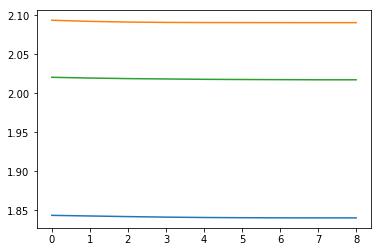

In [54]:
error_array_list = plot_k_model_selection(np.arange(1,10,1), y_list, y_names, permuted_index_list)

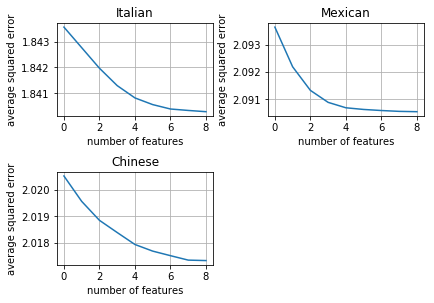

In [55]:
from matplotlib.ticker import NullFormatter
x = np.arange(0, len(np.arange(1,10,1)), 1)
y = error_array_list

# plot with various axes scales
plt.figure()

# linear
plt.subplot(221)
plt.plot(x, y[0])
plt.title('Italian')
plt.xlabel('number of features')
plt.ylabel('average squared error')
plt.grid(True)

# log
plt.subplot(222)
plt.plot(x, y[1])
plt.title('Mexican')
plt.xlabel('number of features')
plt.ylabel('average squared error')
plt.grid(True)

# logit
plt.subplot(223)
plt.plot(x, y[2])
plt.title('Chinese')
plt.xlabel('number of features')
plt.ylabel('average squared error')
plt.grid(True)

plt.gca().yaxis.set_minor_formatter(NullFormatter())
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.6,
                    wspace=0.35)

plt.show()